# Une représentation des inégalités scolaires










## Préliminaire - Installation des packages nécessaires 

In [2]:
!pip install pathlib2
!pip install python-Levenshtein
!pip install --upgrade xlrd
!pip install git+https://github.com/InseeFrLab/Py-Insee-Data.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 6.1 MB/s eta 0:00:00
  Cloning https://github.com/InseeFrLab/Py-Insee-Data.git to /tmp/pip-req-build-6dtqgbob
  Running command git clone --filter=blob:none --quiet https://github.com/InseeFrLab/Py-Insee-Data.git /tmp/pip-req-build-6dtqgbob
  Resolved https://github.com/InseeFrLab/Py-Insee-Data.git to commit e74df7d0125aeba38402b735af7872b2c381d803
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 9.5 MB/s eta 0:00:00
  Created wheel for pynsee: filename=pynsee-0.1.2-py3-none-any.whl size=9805116 sha256=37d621230be2d5e015ede44e7effaf55a4d1579865aa79de51f79f778bb77caf
  Stored in directory: /tmp/pip-ephem-wheel-cache-zm

In [3]:
import requests
url = 'https://github.com/InseeFrLab/Py-Insee-Data/archive/refs/heads/master.zip'
r = requests.get(url)
with open("pynsee.zip" , 'wb') as zipfile:
    zipfile.write(r.content)


In [4]:
!pip install --ignore-installed pynsee.zip
!pip install python-Levenshtein
!pip install openpyxl


Processing ./pynsee.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Unidecode-1.3.6-py3-none-any.whl (235 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.1 MB/s eta 0:00:00a 0:00:01
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 17.5 MB/s eta 0:00:0000:0100:01
  Using cached pathlib-1.0.1-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 16.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 kB 13.3 MB/s eta 0:00:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pynsee.download
import seaborn as sns

## I - Ouverture et manipulation des bases de données

### A - La base de données sur les résultats par données

On ouvre cette base de données à partir du fichier stocké dans le Datalab.

On s'intéresse d'abord à la feuille contenant les données pour les lycées généraux et technologiques. 
On supprime les colonnes qui ne nous seront pas utiles (sur les taux attendus et les effectifs).

In [6]:
#file_name = "ival-2021---complet-xlsx-112652.xlsx"
df = pd.read_excel ("ival-2021---complet-xlsx-112652.xlsx", header = [0,1])

fichier_LGT = df.copy()
fichier_LGT = fichier_LGT.drop (["Valeur ajoutée du taux d'accès"], axis = 1)
fichier_LGT = fichier_LGT.drop(["Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus", "Taux de mentions bruts", "Valeur ajoutée de taux de mentions"], axis = 1)

/tmp/ipykernel_155/339728722.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  fichier_LGT = fichier_LGT.drop (["Valeur ajoutée du taux d'accès"], axis = 1)
/tmp/ipykernel_155/339728722.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  fichier_LGT = fichier_LGT.drop(["Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus", "Taux de mentions bruts", "Valeur ajoutée de taux de mentions"], axis = 1)


Les données concernant les bacs technologiques étant divisées par filière, nous regroupons toutes les filières sous une colonne technologique. 

On commence par remplacer les valeurs non existantes par des zéros. 
Puis, on calcule le nombre d'élèves présents au bac technologique. 

In [9]:
fichier_LGT = fichier_LGT.fillna(0)
#fichier.loc[:,("Nombre d'élèves présents au Bac","Somme Pro")] = fichier["Nombre d'élèves présents au Bac", "STMG"] + fichier["Nombre d'élèves présents au Bac", "STI2D"] + fichier["Nombre d'élèves présents au Bac", "STD2A"]+fichier["Nombre d'élèves présents au Bac", "STL"]+df_rose["Nombre d'élèves présents au Bac", "ST2S"]+fichier["Nombre d'élèves présents au Bac", "S2TMD"]+fichier["Nombre d'élèves présents au Bac", "STHR"]#
fichier_LGT.loc[:,("Nombre d'élèves présents au Bac","Somme Techno")] = fichier_LGT["Nombre d'élèves présents au Bac", 'TOTAL']- fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"]
fichier_LGT["Nombre d'élèves présents au Bac"]


,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL,Somme Techno
0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54,0.0
1,122.0,28.0,0.0,0.0,0.0,50.0,0.0,0.0,200,78.0
2,98.0,0.0,41.0,0.0,26.0,0.0,0.0,0.0,165,67.0
3,174.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,234,60.0
4,160.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0,214,54.0
...,...,...,...,...,...,...,...,...,...,...
2311,246.0,105.0,0.0,0.0,47.0,56.0,0.0,0.0,454,208.0
2312,244.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,360,116.0
2313,325.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,325,0.0
2314,221.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,251,30.0


On calcule les totaux de taux de réussite bruts pour les filières technologiques. 

In [10]:
#test = ((fichier_LGT["Taux de réussite bruts", "TOTAL"]*fichier_LGT["Nombre d'élèves présents au Bac", "TOTAL"])-(fichier_LGT["Taux de réussite bruts", "GNLE"]*fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"]))/fichier_LGT["Nombre d'élèves présents au Bac", "Somme Techno"]
#fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Taux de réussite bruts", "Taux brut techno")] = (fichier_LGT["Taux de réussite bruts", "TOTAL"]*fichier_LGT["Nombre d'élèves présents au Bac", "TOTAL"] - fichier_LGT["Taux de réussite bruts", "GNLE"]*fichier_LGT["Nombre d'élèves présents au Bac", "GNLE"])/fichier_LGT["Nombre d'élèves présents au Bac", "Somme Techno"]#
stmg = fichier_LGT["Taux de réussite bruts", "STMG"]*fichier_LGT["Nombre d'élèves présents au Bac", "STMG"]
sti2d = fichier_LGT["Taux de réussite bruts", "STI2D"]*fichier_LGT["Nombre d'élèves présents au Bac", "STI2D"]
std2a = fichier_LGT["Taux de réussite bruts", "STD2A"]*fichier_LGT["Nombre d'élèves présents au Bac", "STD2A"]
stl = fichier_LGT["Taux de réussite bruts", "STL"]*fichier_LGT["Nombre d'élèves présents au Bac", "STL"]
st2s = fichier_LGT["Taux de réussite bruts", "ST2S"]*fichier_LGT["Nombre d'élèves présents au Bac", "ST2S"]
s2tmd = fichier_LGT["Taux de réussite bruts", "S2TMD"]*fichier_LGT["Nombre d'élèves présents au Bac", "S2TMD"]
sthr = fichier_LGT["Taux de réussite bruts", "STHR"]*fichier_LGT["Nombre d'élèves présents au Bac", "STHR"]
taux_tech_brut = (stmg + sti2d + std2a + stl + st2s + s2tmd + sthr)/fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"]


fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Taux de réussite bruts", "Taux brut techno")] = taux_tech_brut #>0.5 pour éviter erreurs d'arrondi de flottants#
fichier_LGT["Taux de réussite bruts"]
#pb avec test à cause des arrondis dans TOTAL (int pas float), résolu avec taux_techno #
#on ne peut pas le faire avec les taux de réussite attendus car on les a enlevé #
#on ne peut pas le faire avec la valeur ajoutée car mauvais type d’objet (on peut en tout cas le faire si besoin à partir du taux attendu et brut si on remet le taux attendu#


,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL,Taux brut techno
0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98,0.000000
1,99.0,96.0,0.0,0.0,0.0,92.0,0.0,0.0,97,93.435897
2,100.0,0.0,100.0,0.0,96.0,0.0,0.0,0.0,99,98.447761
3,97.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,96,93.000000
4,99.0,0.0,96.0,0.0,0.0,0.0,0.0,0.0,99,96.000000
...,...,...,...,...,...,...,...,...,...,...
2311,99.0,99.0,0.0,0.0,96.0,91.0,0.0,0.0,98,96.168269
2312,100.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,100,99.000000
2313,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100,0.000000
2314,99.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,99,100.000000


On calcule ces mêmes totaux pour les valeurs ajoutées. La difficulté réside dans le format des données dans les colonnes valeur ajoutée.

In [11]:
#Il faut remplacer les taux non définis par des NaN et transformer en flottant#
liste= ["GNLE", "STMG", "STI2D", "STD2A", "STL", "ST2S", "S2TMD", "STHR", "TOTAL"]
for i in liste:
    fichier_LGT.loc[fichier_LGT["Valeur ajoutée du taux de réussite", i] == "ND", ("Valeur ajoutée du taux de réussite", i)] = np.NaN
    fichier_LGT["Valeur ajoutée du taux de réussite", i] = pd.to_numeric(fichier_LGT["Valeur ajoutée du taux de réussite", i])
fichier_LGT["Valeur ajoutée du taux de réussite"].info()
fichier_LGT["Valeur ajoutée du taux de réussite"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2316 entries, 0 to 2315
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GNLE    2301 non-null   float64
 1   STMG    2295 non-null   float64
 2   STI2D   2309 non-null   float64
 3   STD2A   2314 non-null   float64
 4   STL     2294 non-null   float64
 5   ST2S    2308 non-null   float64
 6   S2TMD   2311 non-null   float64
 7   STHR    2312 non-null   float64
 8   TOTAL   2301 non-null   float64
dtypes: float64(9)
memory usage: 163.0 KB


,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,2.0,5.0,0.0,0.0,0.0,-5.0,0.0,0.0,1.0
2,1.0,0.0,2.0,0.0,-1.0,0.0,0.0,0.0,1.0
3,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2311,0.0,1.0,0.0,0.0,-1.0,-5.0,0.0,0.0,0.0
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2314,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0


In [12]:
#calcul de la valeur ajoutée du taux de réussite pour les bacs techno, reprend tout pour éviter les problèmes d'arrondis#
stmg = fichier_LGT["Valeur ajoutée du taux de réussite", "STMG"]*fichier_LGT["Nombre d'élèves présents au Bac", "STMG"]
sti2d = fichier_LGT["Valeur ajoutée du taux de réussite", "STI2D"]*fichier_LGT["Nombre d'élèves présents au Bac", "STI2D"]
std2a = fichier_LGT["Valeur ajoutée du taux de réussite", "STD2A"]*fichier_LGT["Nombre d'élèves présents au Bac", "STD2A"]
stl = fichier_LGT["Valeur ajoutée du taux de réussite", "STL"]*fichier_LGT["Nombre d'élèves présents au Bac", "STL"]
st2s = fichier_LGT["Valeur ajoutée du taux de réussite", "ST2S"]*fichier_LGT["Nombre d'élèves présents au Bac", "ST2S"]
s2tmd = fichier_LGT["Valeur ajoutée du taux de réussite", "S2TMD"]*fichier_LGT["Nombre d'élèves présents au Bac", "S2TMD"]
sthr = fichier_LGT["Valeur ajoutée du taux de réussite", "STHR"]*fichier_LGT["Nombre d'élèves présents au Bac", "STHR"]
val_aj_tech = (stmg + sti2d + std2a + stl + st2s + s2tmd + sthr)/fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"]


fichier_LGT.loc[(fichier_LGT["Nombre d'élèves présents au Bac","Somme Techno"] > 0.5),("Valeur ajoutée du taux de réussite", "Valeur ajoutée techno")] = val_aj_tech #>0.5 pour éviter les problèmes d'arrondis de flottants#
fichier_LGT["Valeur ajoutée du taux de réussite"]

,GNLE,STMG,STI2D,STD2A,STL,ST2S,S2TMD,STHR,TOTAL,Valeur ajoutée techno
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN
1,2.0,5.0,0.0,0.0,0.0,-5.0,0.0,0.0,1.0,-1.410256
2,1.0,0.0,2.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.835821
3,-1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-2.000000
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.000000
...,...,...,...,...,...,...,...,...,...,...
2311,0.0,1.0,0.0,0.0,-1.0,-5.0,0.0,0.0,0.0,-1.067308
2312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2314,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,2.000000


On ré-indexe également la base des lycées généraux et technologiques pour faciliter les manipulations suivantes : nous allons effacer les informations relatives à des filières technologiques spécifiques étant donné qu'on s'intéresse seulement aux bacs technologiques en général.

In [13]:
fichier_LGT.columns = fichier_LGT.columns.map('_'.join).str.strip('_')
fichier_LGT = fichier_LGT.drop(["Nombre d'élèves présents au Bac_STMG","Nombre d'élèves présents au Bac_STI2D", "Nombre d'élèves présents au Bac_STD2A", "Nombre d'élèves présents au Bac_STL", "Nombre d'élèves présents au Bac_ST2S","Nombre d'élèves présents au Bac_S2TMD", "Nombre d'élèves présents au Bac_STHR", "Taux de réussite bruts_STMG",
"Taux de réussite bruts_STI2D","Taux de réussite bruts_STD2A","Taux de réussite bruts_STL","Taux de réussite bruts_ST2S","Taux de réussite bruts_S2TMD","Taux de réussite bruts_STHR", "Valeur ajoutée du taux de réussite_STMG","Valeur ajoutée du taux de réussite_STI2D","Valeur ajoutée du taux de réussite_STD2A", "Valeur ajoutée du taux de réussite_STL", "Valeur ajoutée du taux de réussite_ST2S", "Valeur ajoutée du taux de réussite_S2TMD", "Valeur ajoutée du taux de réussite_STHR"], axis=1)

On passe ensuite à la feuille concernant les lycées professionnels. Nous avons renommé certaines colonnes afin d'afficher à part les résultats au bac professionnel par rapport aux autres filières lorsqu'on concatènera cette feuille avec celle des lycées généraux et technologiques.

In [14]:
df2 = pd.read_excel ("ival-2021---complet-xlsx-112652.xlsx", sheet_name = 1, header = [0,1])

fichier_LP = df2.copy()
fichier_LP = fichier_LP.drop (["Valeur ajoutée du taux d'accès", "Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus"], axis = 1)
fichier_LP.columns = fichier_LP.columns.map('_'.join).str.strip('_')
col_cons = ['Informations établissement_Académie', 'Informations établissement_Département', 'Informations établissement_Etablissement', 'Informations établissement_Ville', 'Informations établissement_UAI', 'Informations établissement_Code commune', 'Informations établissement_Secteur', "Nombre d'élèves présents au Bac_TOTAL", 'Taux de réussite bruts_TOTAL', 'Valeur ajoutée du taux de réussite_TOTAL']
fichier_LP = fichier_LP[col_cons]
fichier_LP = fichier_LP.rename(columns={"Nombre d'élèves présents au Bac_TOTAL": "Nombre d'élèves présents au Bac_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Taux de réussite bruts_TOTAL" : "Taux de réussite bruts_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Taux de mentions bruts_TOTAL" : "Taux de mentions bruts_TOTAL_Pro"})
fichier_LP = fichier_LP.rename(columns={"Valeur ajoutée du taux de réussite_TOTAL" : "Valeur ajoutée du taux de réussite_TOTAL_Pro"})
fichier_LP

/tmp/ipykernel_155/958335156.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  fichier_LP = fichier_LP.drop (["Valeur ajoutée du taux d'accès", "Taux d'accès attendus", "Taux d'accès bruts", "Effectifs à la rentrée 2021", "Taux de mentions attendus", "Taux de réussite attendus"], axis = 1)


,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Informations établissement_UAI,Informations établissement_Code commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Valeur ajoutée du taux de réussite_TOTAL_Pro
0,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,0040003G,04019,PU,15,87,-2
1,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PROFESSIONNEL BEAU DE ROCHAS,DIGNE LES BAINS,0040007L,04070,PU,104,87,+1
2,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE LES ISCLES (PROFESSIONNEL),MANOSQUE,0040533H,04112,PU,28,89,+2
3,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PROFESSIONNEL LOUIS MARTIN BRET,MANOSQUE,0040011R,04112,PU,146,79,-8
4,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PAUL ARENE (PROFESSIONNEL),SISTERON,0040023D,04209,PU,37,89,-3
...,...,...,...,...,...,...,...,...,...,...
2008,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,0782603F,78646,PU,154,82,-3
2009,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,0782100J,78646,PR,41,98,+1
2010,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,0781582W,78646,PR,45,98,+3
2011,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL ST VINCENT DE PAUL,VERSAILLES,0783325R,78646,PR,95,96,+2


Nous allons désormais concaténer les deux feuilles afin d'avoir sur une même DataFrame les informations concernant les baccalauréats généraux, technologiques et professionnels.

In [15]:
dftotale = pd.concat([fichier_LGT, fichier_LP])
dftotale

,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Informations établissement_UAI,Informations établissement_Code commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Nombre d'élèves présents au Bac_TOTAL,Taux de réussite bruts_GNLE,Taux de réussite bruts_TOTAL,Valeur ajoutée du taux de réussite_GNLE,Valeur ajoutée du taux de réussite_TOTAL,Nombre d'élèves présents au Bac_Somme Techno,Taux de réussite bruts_Taux brut techno,Valeur ajoutée du taux de réussite_Valeur ajoutée techno,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Valeur ajoutée du taux de réussite_TOTAL_Pro
0,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,0040003G,04019,PU,54.0,54.0,98.0,98.0,4.0,4.0,0.0,0.000000,NaN,NaN,NaN,NaN
1,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,0040027H,04070,PU,122.0,200.0,99.0,97.0,2.0,1.0,78.0,93.435897,-1.410256,NaN,NaN,NaN
2,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,0040490L,04070,PU,98.0,165.0,100.0,99.0,1.0,1.0,67.0,98.447761,0.835821,NaN,NaN,NaN
3,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,0040010P,04112,PU,174.0,234.0,97.0,96.0,-1.0,-1.0,60.0,93.000000,-2.000000,NaN,NaN,NaN
4,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE LES ISCLES (GENERAL ET TECHNO.),MANOSQUE,0040533H,04112,PU,160.0,214.0,99.0,99.0,0.0,1.0,54.0,96.000000,-1.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,0782603F,78646,PU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.0,82.0,-3
2009,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,0782100J,78646,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,98.0,+1
2010,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,0781582W,78646,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,98.0,+3
2011,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL ST VINCENT DE PAUL,VERSAILLES,0783325R,78646,PR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,96.0,+2


Nous allons maintenant procéder au nettoyage d'une base de données regroupant diverses informations sur les communes françaises : nombre d'habitants, de foyers fiscaux, diverses informations sur la répartition des revenus etc...
L'objectif sera de la fusionner avec notre base de données des lycées afin d'associer à chaque lycée le revenu médian de la ville dans laquelle il se situe (et éventuellement d'autres informations à caractère socio-économique). 

Dans un premier temps, nous allons retirer un certain nombre de colonnes qui ne nous intéresse pas. Nous souhaitons simplement garder les informations qui pourront nous permettre de fusionner les bases de données (les codes et libellés), les informations sur la taille des populations et le revenu médian de la commune que nous choisissons comme mesure de la situation économique des habitants. Le reste ne nous sera pas utile.

In [16]:
df_communes = pd.read_excel("FILO2019_DEC_COM.xlsx", sheet_name = 1, header=[4,5])
df_com = df_communes.copy()
df_com = df_com.drop(['PMIMP19', 'Q119', 'Q319','Q3_Q1','D119', 'D219', 'D319', 'D419', 'D619', 'D719', 'D819', 'D919', 'RD', 'S80S2019', 'GI19', 'PACT19', 'PTSA19', 'PCHO19', 'PBEN19', 'PPEN19', 'PAUT19'], axis = 1, level = 1 )
df_com

,Code géographique,Libellé géographique,Nbre de ménages fiscaux,Nbre de personnes dans les ménages fiscaux,Nbre d'unités de consommation dans les ménages fiscaux,Médiane (€)
,CODGEO,LIBGEO,NBMEN19,NBPERS19,NBUC19,Q219
0,01001,L'Abergement-Clémenciat,322,819,542.7,24210
1,01002,L'Abergement-de-Varey,114,267,179.5,23380
2,01004,Ambérieu-en-Bugey,6713,15041,10298.9,19690
3,01005,Ambérieux-en-Dombes,720,1823,1204.3,24100
4,01007,Ambronay,1163,2857,1892.3,23340
...,...,...,...,...,...,...
31359,97420,Sainte-Suzanne,8346,23842,15051.4,14100
31360,97421,Salazie,2469,6936,4407.0,7740
31361,97422,Le Tampon,30083,78013,50752.2,12370


Nous allons joindre la DataFrame des lycées et celle des communes pour avoir pour chaque lycée le revenu médian de la ville associée. 

In [17]:
df_com.columns = df_com.columns.map('_'.join).str.strip('_') #On indexe de manière simple la base de données des communes pour faciliter la jointure
dflyccom = pd.merge(dftotale, df_com, how='left', left_on='Informations établissement_Code commune', right_on='Code géographique_CODGEO')
dflyccom

,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Informations établissement_UAI,Informations établissement_Code commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Nombre d'élèves présents au Bac_TOTAL,Taux de réussite bruts_GNLE,...,Valeur ajoutée du taux de réussite_Valeur ajoutée techno,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Valeur ajoutée du taux de réussite_TOTAL_Pro,Code géographique_CODGEO,Libellé géographique_LIBGEO,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219
0,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,0040003G,04019,PU,54.0,54.0,98.0,...,NaN,NaN,NaN,NaN,04019,Barcelonnette,1400.0,2490.0,1888.7,19070.0
1,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,0040027H,04070,PU,122.0,200.0,99.0,...,-1.410256,NaN,NaN,NaN,04070,Digne-les-Bains,7953.0,15531.0,11316.4,19840.0
2,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,0040490L,04070,PU,98.0,165.0,100.0,...,0.835821,NaN,NaN,NaN,04070,Digne-les-Bains,7953.0,15531.0,11316.4,19840.0
3,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,0040010P,04112,PU,174.0,234.0,97.0,...,-2.000000,NaN,NaN,NaN,04112,Manosque,10413.0,21980.0,15467.9,19270.0
4,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE LES ISCLES (GENERAL ET TECHNO.),MANOSQUE,0040533H,04112,PU,160.0,214.0,99.0,...,-1.000000,NaN,NaN,NaN,04112,Manosque,10413.0,21980.0,15467.9,19270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,0782603F,78646,PU,NaN,NaN,NaN,...,NaN,154.0,82.0,-3,78646,Versailles,36130.0,85251.0,57650.2,34730.0
4325,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,0782100J,78646,PR,NaN,NaN,NaN,...,NaN,41.0,98.0,+1,78646,Versailles,36130.0,85251.0,57650.2,34730.0
4326,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,0781582W,78646,PR,NaN,NaN,NaN,...,NaN,45.0,98.0,+3,78646,Versailles,36130.0,85251.0,57650.2,34730.0
4327,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL ST VINCENT DE PAUL,VERSAILLES,0783325R,78646,PR,NaN,NaN,NaN,...,NaN,95.0,96.0,+2,78646,Versailles,36130.0,85251.0,57650.2,34730.0


Etant donné que nous aurons besoin de coordonnées spatiales pour créer des cartes lors de la partie visualisation, nous allons concaténer à notre base de données les coordonnées géographique des établissements scolaires.

Nous allons donc utiliser l'annuaire de l'éducation nationale pour récupérer ces informations en conservant seulement les informations nécessaires pour effectuer la jointure et les données géographiques. Nous réordonnons également les colonnes dans la base de données définitive et renommons les colonnes propres aux filières technologiques et générales afin d'éviter toute confusion. Nous supprimons les colonnes redondantes. 

In [18]:
geographique = pd.read_excel('fr-en-annuaire-education.xls')   
col_cons = ['Identifiant_de_l_etablissement', 'Code_commune', 'coordonnee_X', 'coordonnee_Y', 'epsg', 'latitude', 'longitude']
geo = geographique[col_cons]

dfdef = dflyccom.merge(geo, how='inner', left_on='Informations établissement_UAI', right_on='Identifiant_de_l_etablissement')
dfdef = dfdef[['Identifiant_de_l_etablissement', 'Informations établissement_Académie','Informations établissement_Département','Informations établissement_Etablissement','Informations établissement_Ville', "Code_commune",
"Informations établissement_Secteur", "Nombre d'élèves présents au Bac_GNLE", "Taux de réussite bruts_GNLE", "Valeur ajoutée du taux de réussite_GNLE", "Nombre d'élèves présents au Bac_Somme Techno",
"Taux de réussite bruts_Taux brut techno", "Valeur ajoutée du taux de réussite_Valeur ajoutée techno", "Nombre d'élèves présents au Bac_TOTAL", "Taux de réussite bruts_TOTAL","Valeur ajoutée du taux de réussite_TOTAL", "Nombre d'élèves présents au Bac_TOTAL_Pro",
"Taux de réussite bruts_TOTAL_Pro","Valeur ajoutée du taux de réussite_TOTAL_Pro", "Nbre de ménages fiscaux_NBMEN19", "Nbre de personnes dans les ménages fiscaux_NBPERS19","Nbre d'unités de consommation dans les ménages fiscaux_NBUC19","Médiane (€)_Q219", "coordonnee_X", "coordonnee_Y",
"epsg", "latitude","longitude" ]]
dfdef = dfdef.rename(columns={"Nombre d'élèves présents au Bac_TOTAL" : "Nombre d'élèves présents au Bac_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Taux de réussite bruts_TOTAL" : "Taux de réussite bruts_TOTAL_LGT"})
dfdef = dfdef.rename(columns={"Valeur ajoutée du taux de réussite_TOTAL" : "Valeur ajoutée du taux de réussite_TOTAL_LGT"})

Nous allons désormais procéder au nettoyage des données. En effet, des zéros sont présents dans des cases qu'on voudrait ne pas prendre en compte dans notre traitement statistique. Il faut donc les remplacer par des NaN. Par exemple, on voudrait que les lycées qui ne présentent pas de candidats au bac général ne soit pas associé à 0% de taux de réussite étant donné qu'il n'y a aucun élève. 

In [19]:
dfdef["Nombre d'élèves présents au Bac_GNLE"]= dfdef["Nombre d'élèves présents au Bac_GNLE"].replace(0, np.nan)
dfdef["Nombre d'élèves présents au Bac_Somme Techno"] = dfdef["Nombre d'élèves présents au Bac_Somme Techno"].replace(0, np.nan)
dfdef["Nombre d'élèves présents au Bac_TOTAL_Pro"] = dfdef["Nombre d'élèves présents au Bac_TOTAL_Pro"].replace(0, np.nan)
for i in range(4396):
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_GNLE"])==True: #Si personne ne s'est présenté au bac général
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_GNLE"] = np.nan #On n'associe pas de valeur au taux de réussite brut
        dfdef.loc[dfdef.index[i],"Valeur ajoutée du taux de réussite_GNLE"] = np.nan #On n'associe pas de valeur à la valeur ajoutée du taux de réussite
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_Somme Techno"])==True: #Bac technologique 
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_Taux brut techno"] = np.nan
        dfdef.loc[dfdef.index[i],"Valeur ajoutée du taux de réussite_Valeur ajoutée techno"] = np.nan
    if np.isnan(dfdef.loc[dfdef.index[i], "Nombre d'élèves présents au Bac_TOTAL_Pro"])==True: #Bac Pro
        dfdef.loc[dfdef.index[i],"Taux de réussite bruts_TOTAL_Pro"] = np.nan
        dfdef.loc[dfdef.index[i], "Valeur ajoutée du taux de réussite_TOTAL_Pro"] =np.nan
dfdef

,Identifiant_de_l_etablissement,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Code_commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,...,Valeur ajoutée du taux de réussite_TOTAL_Pro,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,coordonnee_X,coordonnee_Y,epsg,latitude,longitude
0,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,04019,PU,54.0,98.0,4.0,...,NaN,1400.0,2490.0,1888.7,19070.0,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
1,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,04019,PU,NaN,NaN,NaN,...,-2,1400.0,2490.0,1888.7,19070.0,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
2,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,04070,PU,122.0,99.0,2.0,...,NaN,7953.0,15531.0,11316.4,19840.0,958859.0,6338835.0,EPSG:2154,44.100803,6.234041
3,0040490L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,04070,PU,98.0,100.0,1.0,...,NaN,7953.0,15531.0,11316.4,19840.0,954812.0,6335664.0,EPSG:2154,44.073766,6.181939
4,0040010P,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,04112,PU,174.0,97.0,-1.0,...,NaN,10413.0,21980.0,15467.9,19270.0,923669.0,6308250.0,EPSG:2154,43.837805,5.781337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4391,0780273Y,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LOUIS BLERIOT,TRAPPES,78621,PU,NaN,NaN,NaN,...,0,11751.0,33579.0,20954.6,15420.0,625524.2,6853470.3,EPSG:2154,48.777026,1.986500
4392,0782603F,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,78646,PU,NaN,NaN,NaN,...,-3,36130.0,85251.0,57650.2,34730.0,637563.4,6856960.8,EPSG:2154,48.809694,2.149810
4393,0782100J,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,78646,PR,NaN,NaN,NaN,...,+1,36130.0,85251.0,57650.2,34730.0,637144.1,6857845.7,EPSG:2154,48.817611,2.143970
4394,0781582W,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,78646,PR,NaN,NaN,NaN,...,+3,36130.0,85251.0,57650.2,34730.0,635721.0,6855065.5,EPSG:2154,48.792468,2.125010


On enlève aussi les académies d'outre-mer car nous n'avons pas le revenu médian des communes

In [20]:
dfdef = dfdef[dfdef['Informations établissement_Académie']!= 'GUADELOUPE'] 
dfdef = dfdef[dfdef['Informations établissement_Académie']!= 'MARTINIQUE']
dfdef = dfdef[dfdef['Informations établissement_Académie']!='GUYANE']
dfdef = dfdef[dfdef['Informations établissement_Académie']!='MAYOTTE']
dfdef = dfdef[ dfdef['Informations établissement_Académie']!='LA REUNION']

In [21]:
dfdef.to_excel('base_définitive.xlsx') #On exporte directement cette base de données pour ne pas avoir à relancer toute la manipulation quand on travaille

## II - Les premières statistiques descriptives

Nous allons effectuer quelques statistiques descriptives sur la base de données que nous venons de créer.
Dans un premier temps, nous allons la récupérer sous la variable qu'on nommera df.

In [22]:
df = pd.read_excel ("base_définitive.xlsx")
df = df.drop("Unnamed: 0", axis=1)
df

,Identifiant_de_l_etablissement,Informations établissement_Académie,Informations établissement_Département,Informations établissement_Etablissement,Informations établissement_Ville,Code_commune,Informations établissement_Secteur,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,...,Valeur ajoutée du taux de réussite_TOTAL_Pro,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,coordonnee_X,coordonnee_Y,epsg,latitude,longitude
0,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (GENERAL ET TECHNO.),BARCELONNETTE,04019,PU,54.0,98.0,4.0,...,NaN,1400,2490,1888.7,19070,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
1,0040003G,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ANDRE HONNORAT (PROFESSIONNEL),BARCELONNETTE,04019,PU,NaN,NaN,NaN,...,-2,1400,2490,1888.7,19070,990800.5,6372252.3,EPSG:2154,44.388778,6.651860
2,0040027H,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE ALEXANDRA DAVID NEEL,DIGNE LES BAINS,04070,PU,122.0,99.0,2.0,...,NaN,7953,15531,11316.4,19840,958859.0,6338835.0,EPSG:2154,44.100803,6.234041
3,0040490L,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE PIERRE-GILLES DE GENNES,DIGNE LES BAINS,04070,PU,98.0,100.0,1.0,...,NaN,7953,15531,11316.4,19840,954812.0,6335664.0,EPSG:2154,44.073766,6.181939
4,0040010P,AIX-MARSEILLE,ALPES DE HTE PROVENCE,LYCEE FELIX ESCLANGON,MANOSQUE,04112,PU,174.0,97.0,-1.0,...,NaN,10413,21980,15467.9,19270,923669.0,6308250.0,EPSG:2154,43.837805,5.781337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0780273Y,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LOUIS BLERIOT,TRAPPES,78621,PU,NaN,NaN,NaN,...,0,11751,33579,20954.6,15420,625524.2,6853470.3,EPSG:2154,48.777026,1.986500
4205,0782603F,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL JACQUES PREVERT,VERSAILLES,78646,PU,NaN,NaN,NaN,...,-3,36130,85251,57650.2,34730,637563.4,6856960.8,EPSG:2154,48.809694,2.149810
4206,0782100J,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL LES CHATAIGNIERS,VERSAILLES,78646,PR,NaN,NaN,NaN,...,+1,36130,85251,57650.2,34730,637144.1,6857845.7,EPSG:2154,48.817611,2.143970
4207,0781582W,VERSAILLES,YVELINES,LYCEE PROFESSIONNEL NOTRE-DAME DU GRANDCHAMP,VERSAILLES,78646,PR,NaN,NaN,NaN,...,+3,36130,85251,57650.2,34730,635721.0,6855065.5,EPSG:2154,48.792468,2.125010


In [23]:
#Quelques Stats Des qu'on va pas nécessairement utiliser à la fin mais au moins ça donne une première idée
df.count() #Ne nous apprend pas grand chose... 
df.mean() #Affiche sous forme scientifique donc pas ouf mais si on sélectionne certaines valeurs ça peut être intéressant
df.quantile(q = [0.1,0.25,0.5,0.75,0.9]) #On peut choisir les quantiles et produire des trucs intéressants
df.describe()
#Je n'envisage pas de conserver cette partie du code, mais c'est pratique de la garder pour copier/coller

/tmp/ipykernel_155/3080630801.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean() #Affiche sous forme scientifique donc pas ouf mais si on sélectionne certaines valeurs ça peut être intéressant
/tmp/ipykernel_155/3080630801.py:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.quantile(q = [0.1,0.25,0.5,0.75,0.9]) #On peut choisir les quantiles et produire des trucs intéressants


,Nombre d'élèves présents au Bac_GNLE,Taux de réussite bruts_GNLE,Valeur ajoutée du taux de réussite_GNLE,Nombre d'élèves présents au Bac_Somme Techno,Taux de réussite bruts_Taux brut techno,Valeur ajoutée du taux de réussite_Valeur ajoutée techno,Nombre d'élèves présents au Bac_TOTAL_LGT,Taux de réussite bruts_TOTAL_LGT,Valeur ajoutée du taux de réussite_TOTAL_LGT,Nombre d'élèves présents au Bac_TOTAL_Pro,Taux de réussite bruts_TOTAL_Pro,Nbre de ménages fiscaux_NBMEN19,Nbre de personnes dans les ménages fiscaux_NBPERS19,Nbre d'unités de consommation dans les ménages fiscaux_NBUC19,Médiane (€)_Q219,coordonnee_X,coordonnee_Y,latitude,longitude
count,2113.000000,2113.000000,2110.000000,1760.000000,1760.000000,1716.000000,2261.000000,2261.000000,2258.000000,1948.000000,1948.000000,4209.000000,4209.000000,4209.000000,4209.000000,4.209000e+03,4.209000e+03,4209.000000,4209.000000
mean,173.042120,97.985802,-0.243128,74.481250,95.249092,-0.457656,219.692614,97.329500,-0.279008,79.892197,87.121663,26222.480399,53973.266572,38313.931314,20928.130197,6.750376e+05,6.674955e+06,47.143101,2.653631
std,95.777063,2.423408,2.021257,49.502685,4.836174,4.042250,127.256447,2.967339,2.244890,44.493066,8.828101,35614.792836,70439.760826,50732.172532,5561.488977,2.022445e+05,2.495369e+05,2.249698,2.654397
min,10.000000,80.000000,-15.000000,5.000000,67.000000,-27.000000,20.000000,68.000000,-26.000000,10.000000,20.000000,151.000000,343.000000,243.800000,7800.000000,1.438587e+05,6.076079e+06,41.598662,-4.524620
25%,97.000000,97.000000,-1.000000,34.000000,92.947647,-2.397039,114.000000,96.000000,-1.000000,46.000000,82.000000,5189.000000,11119.000000,7867.900000,17870.000000,5.611178e+05,6.475882e+06,45.362740,1.121640
50%,162.000000,99.000000,0.000000,66.000000,96.158410,0.326007,208.000000,98.000000,0.000000,74.000000,88.000000,12673.000000,27657.000000,19466.100000,19710.000000,6.604946e+05,6.752674e+06,47.804474,2.459480
75%,239.000000,100.000000,1.000000,100.000000,100.000000,2.000000,312.000000,100.000000,1.000000,106.000000,94.000000,29755.000000,63857.000000,44073.900000,22240.000000,8.406388e+05,6.865164e+06,48.881258,4.812210
max,564.000000,100.000000,11.000000,377.000000,100.000000,11.000000,791.000000,100.000000,9.000000,289.000000,100.000000,220888.000000,426072.000000,309944.600000,52570.000000,1.231320e+06,7.105394e+06,51.042674,9.451509


Afin d'appréhender les données pour savoir dans quelle direction partir, nous allons effectuer des statistiques descriptives générales sur notre base de données par rapport aux variables d'intérêt : taux de réussite ainsi que la médiane des revenus des communes.

In [24]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].describe()

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
count,2113.000000,1760.000000,2261.000000,1948.000000,4209.000000
mean,97.985802,95.249092,97.329500,87.121663,20928.130197
std,2.423408,4.836174,2.967339,8.828101,5561.488977
min,80.000000,67.000000,68.000000,20.000000,7800.000000
25%,97.000000,92.947647,96.000000,82.000000,17870.000000
50%,99.000000,96.158410,98.000000,88.000000,19710.000000
75%,100.000000,100.000000,100.000000,94.000000,22240.000000
max,100.000000,100.000000,100.000000,100.000000,52570.000000


Ce premier describe nous permet d'entrevoir quelques données intéressantes. En effet, la répartition des lycées avec des taux de réussites inférieurs à 95% sont répartis en dessous du premier quartile. Cela signifie qu'il existe des établissement en difficultés bien plus lourdes que la moyenne. 
On effectue l'observation inverse pour la médiane des revenus : les écarts ont l'air plus forts dans les déciles supérieurs. Cela montre donc que la corrélation entre revenu et taux de réussite au bac n'est pas parfaite (même si on traitera plus précisément de ces hypothèses lors de la modélisation)
On pourrait essayer d'afficher en observant par déciles afin d'affiner notre observation.

In [25]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].quantile(q = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
0.0,80.0,67.000000,68.0,20.0,7800.0
0.1,95.0,89.000000,94.0,76.0,16232.0
0.2,97.0,91.858637,95.0,80.0,17450.0
0.3,97.0,93.515556,97.0,83.0,18300.0
0.4,98.0,95.000000,97.0,86.0,19090.0
0.5,99.0,96.158410,98.0,88.0,19710.0
0.6,99.0,97.331638,99.0,90.0,20414.0
0.7,100.0,98.807609,99.0,93.0,21460.0
0.8,100.0,100.000000,100.0,95.0,23170.0
0.9,100.0,100.000000,100.0,98.0,27100.0


On se rend compte que les taux de réussite les plus faibles sont dispersés dans le premier décile. 
De même, les revenus médians sont particulièrement dispersés dans le dernier décile. 
Nous allons donc ajouter quelques quantiles pour avoir plus d'information sur la répartition des valeurs extrêmes.

In [26]:
df[["Taux de réussite bruts_GNLE","Taux de réussite bruts_Taux brut techno","Taux de réussite bruts_TOTAL_LGT","Taux de réussite bruts_TOTAL_Pro","Médiane (€)_Q219"]].quantile(q = [0, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999,1])

,Taux de réussite bruts_GNLE,Taux de réussite bruts_Taux brut techno,Taux de réussite bruts_TOTAL_LGT,Taux de réussite bruts_TOTAL_Pro,Médiane (€)_Q219
0.000,80.000,67.000000,68.0,20.000,7800.0
0.001,83.112,70.277000,78.0,52.947,9990.0
0.010,89.000,79.431938,87.6,62.000,11850.0
0.100,95.000,89.000000,94.0,76.000,16232.0
0.900,100.000,100.000000,100.0,98.000,27100.0
0.990,100.000,100.000000,100.0,100.000,45100.0
0.999,100.000,100.000000,100.0,100.000,52570.0
1.000,100.000,100.000000,100.0,100.000,52570.0


Nous avons désormais une compréhension plus fine de la répartition des valeurs extrêmes. Dans le cas des taux de réussite aux baccalauréats généraux et professionels, on s'aperçoit que leurs minimums est une valeur vraiment extrême car un quantile d'ordre 0.001 prend en compte moins d'une dizaine d'établissement étant donné qu'il y en a moins de 4500 dans l'échantillon total. Pour le bac technologique, on peut faire un constat similaire mais les valeurs extrêmes sont réparties sur le premier percentile. 
Pour les revenus, on s'aperçoit que la dispersion s'effectue bien dans le dernier décile et n'est clairement pas négligeable dans le dernier percentile. 

Cependant, notre analyse ne se concentre pas que sur les taux de réussite au bac. On s'interroge aussi sur les filières dans lesquels les candidats tentent de passer l'examen en fonction du revenu. Tout d'abord, ayons une vue d'ensemble des effectifs.

<BarContainer object of 6 artists>

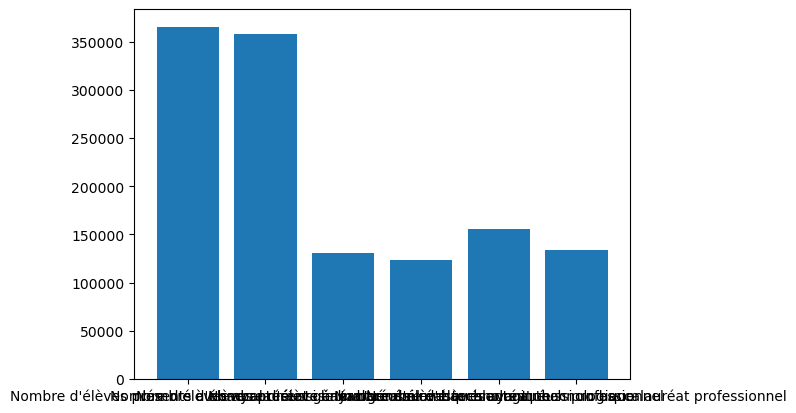

In [27]:
df[["Nombre d'élèves présents au Bac_GNLE","Taux de réussite bruts_GNLE","Nombre d'élèves présents au Bac_Somme Techno","Taux de réussite bruts_Taux brut techno","Nombre d'élèves présents au Bac_TOTAL_Pro","Taux de réussite bruts_TOTAL_Pro"]] 
nbg = df["Nombre d'élèves présents au Bac_GNLE"].sum()
nbgr = np.sum(df["Nombre d'élèves présents au Bac_GNLE"]*df["Taux de réussite bruts_GNLE"])/100
nbt = df["Nombre d'élèves présents au Bac_Somme Techno"].sum()
nbtr = np.sum(df["Nombre d'élèves présents au Bac_Somme Techno"]*df["Taux de réussite bruts_Taux brut techno"])/100
nbp = df["Nombre d'élèves présents au Bac_TOTAL_Pro"].sum()
nbpr = np.sum(df["Nombre d'élèves présents au Bac_TOTAL_Pro"]*df["Taux de réussite bruts_TOTAL_Pro"])/100
plt.bar(["Nombre d'élèves présents au baccalauréat général", "Nombre d'élèves ayant réussi le bac général", "Nombre d'élèves présents à un baccalauréat technologique", "Nombre d'élèves ayant réussi un baccalauréat technologique", "Nombre d'élèves présents au bac professionnel", "Nombre d'élèves ayant réussi un baccalauréat professionnel"],[nbg, nbgr, nbt, nbtr, nbp, nbpr])

<AxesSubplot: ylabel='Informations établissement_Académie'>

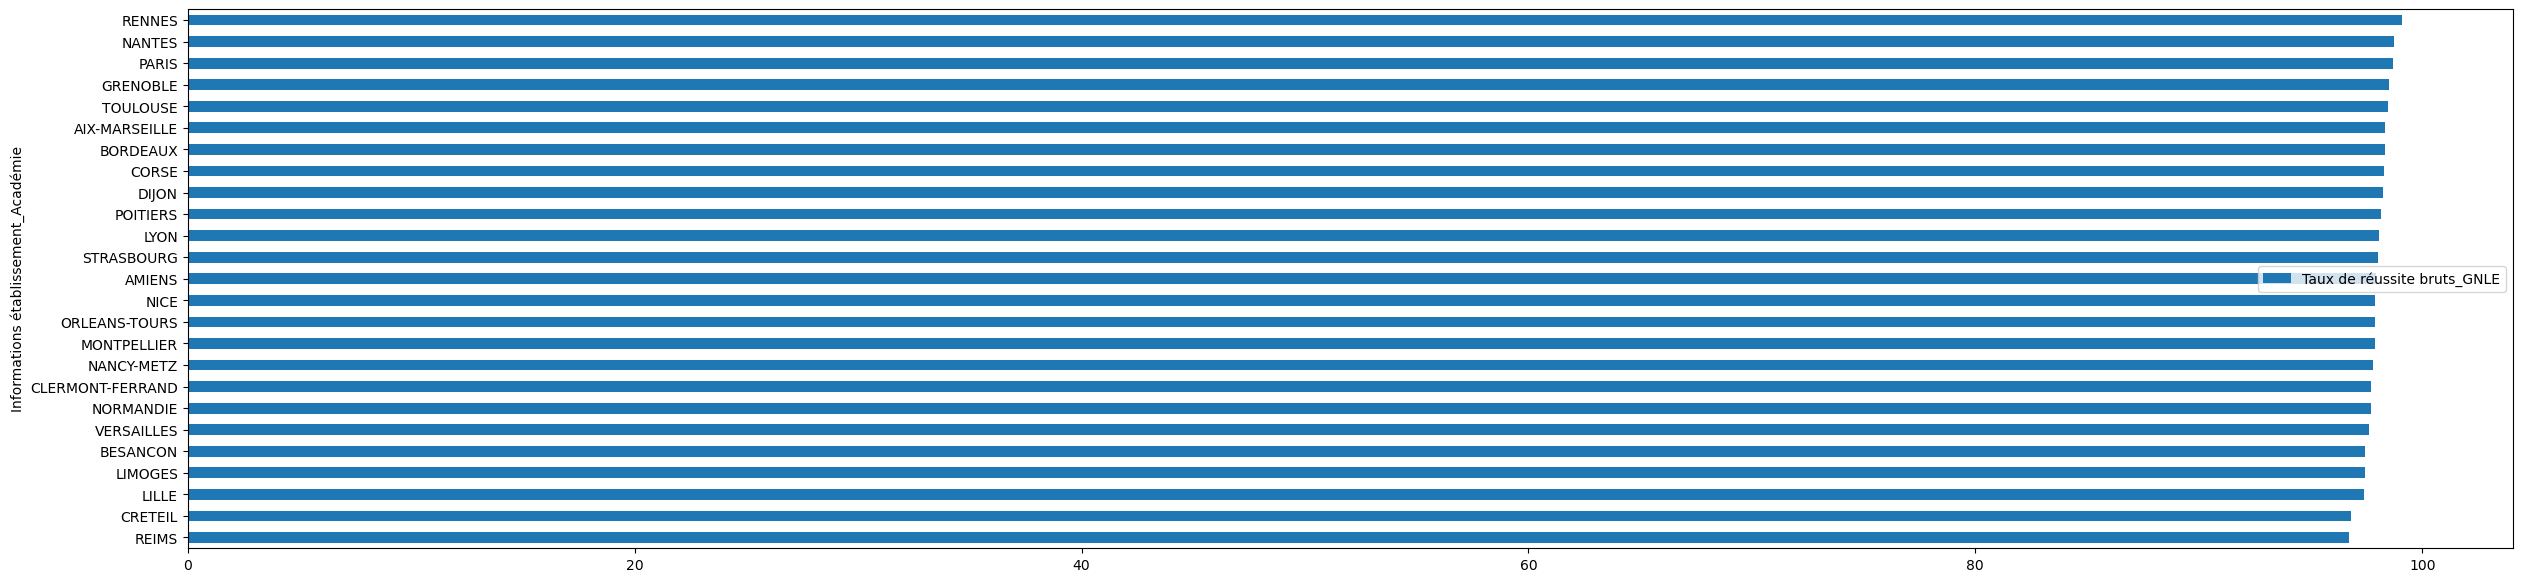

In [28]:
df1 = df.groupby ("Informations établissement_Académie").agg({"Taux de réussite bruts_GNLE":"mean"})
p1 = df1.sort_values ("Taux de réussite bruts_GNLE").plot (kind="barh", figsize = (30,7))
p1

<AxesSubplot: ylabel='Informations établissement_Académie'>

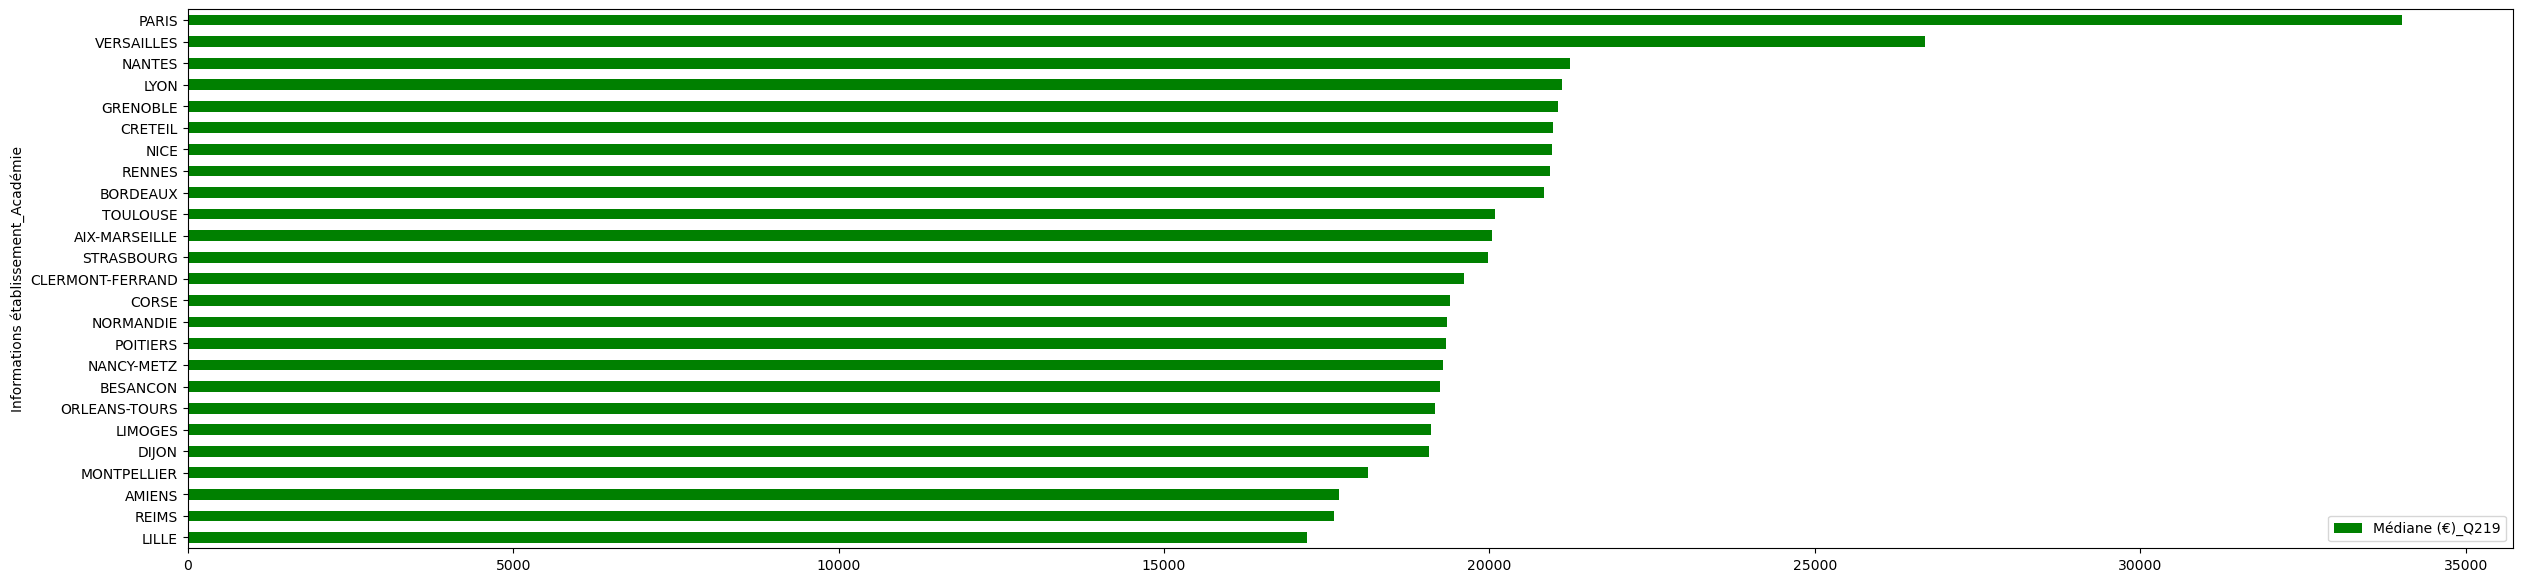

In [29]:
df2 = df.groupby ("Informations établissement_Académie").agg({"Médiane (€)_Q219":"mean"})
p2 = df2.sort_values ("Médiane (€)_Q219").plot (kind="barh", figsize = (30,7), color='green')
p2

In [30]:
df3 = df.loc[:,"Taux de réussite bruts_GNLE"]
df3.index[df.isnull().any(axis=1)]

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208],
           dtype='int64', length=4209)

,Médiane (€)_Q219,Taux de réussite bruts_GNLE
0,19070,98.0
2,19840,99.0
3,19840,100.0
4,19270,97.0
5,19270,99.0
...,...,...
3042,34730,99.0
3043,34730,100.0
3044,34730,100.0
3045,29510,99.0


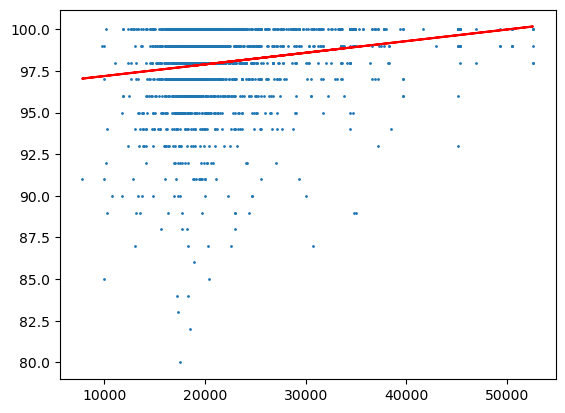

R² =  -12.211310868059796


In [48]:
df_reg = df[[ "Médiane (€)_Q219", "Taux de réussite bruts_GNLE"]]
df_reg = df_reg.dropna(axis = 0, how = "any")
df_reg

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

x = np.array(df_reg[["Médiane (€)_Q219"]])
y = np.array(df_reg[["Taux de réussite bruts_GNLE"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.show()

r2 = r2_score (x, y)
print("R² = ", r2)


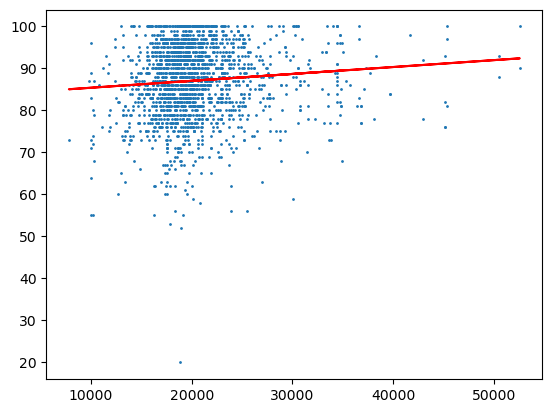

R² =  -17.516539417470632


In [50]:
df_reg_pro = df[[ "Médiane (€)_Q219", "Taux de réussite bruts_TOTAL_Pro"]]
df_reg_pro = df_reg_pro.dropna(axis = 0, how = "any")
df_reg_pro

x = np.array(df_reg_pro[["Médiane (€)_Q219"]])
y = np.array(df_reg_pro[["Taux de réussite bruts_TOTAL_Pro"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.show()

r2 = r2_score (x, y)
print("R² = ", r2)


In [ ]:
df_reg_techno = df[[ "Médiane (€)_Q219", "Taux de réussite bruts_TOTAL_LGT"]]
df_reg_techno = df_reg_techno.dropna(axis = 0, how = "any")
df_reg_tecno

x = np.array(df_reg_pr[["Médiane (€)_Q219"]])
y = np.array(df_reg_pro[["Taux de réussite bruts_TOTAL_LGT"]])

x = x.reshape(-1,1)
y = y.reshape(-1,1)

regression_model = LinearRegression()
regression_model.fit(x,y)
y_predicted = regression_model.predict(x)


plt.scatter(x,y, s=1)
plt.plot(x, y_predicted, color='r')
plt.show()

r2 = r2_score (x, y)
print("R² = ", r2)

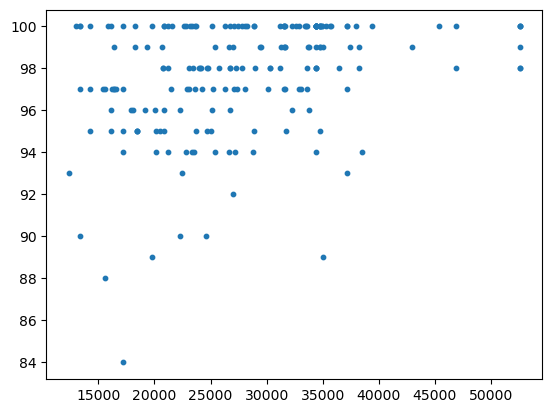

In [111]:
#Hauts revenus
df4 = df.loc[df["Informations établissement_Académie"] == "VERSAILLES"]
df4

x = df4.loc[:,"Médiane (€)_Q219"]
y = df4.loc[:,"Taux de réussite bruts_GNLE"]
plt.scatter(x,y, s=10)
plt.show()

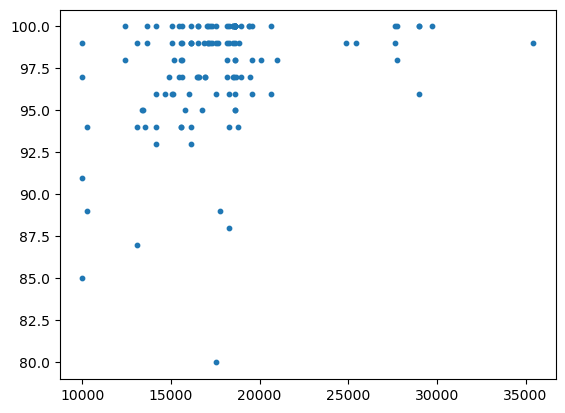

In [112]:
#Bas revenus
df5 = df.loc[df["Informations établissement_Académie"] == "LILLE"]
df5

x = df5.loc[:,"Médiane (€)_Q219"]
y = df5.loc[:,"Taux de réussite bruts_GNLE"]
plt.scatter(x,y, s=10)
plt.show()

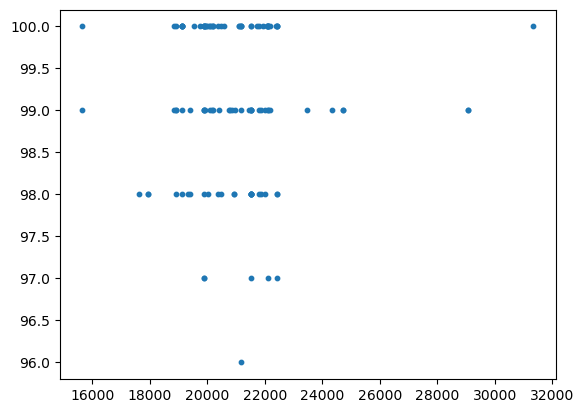

In [113]:
#Hauts taux de réussite
df6 = df.loc[df["Informations établissement_Académie"] == "RENNES"]
df6

x = df6.loc[:,"Médiane (€)_Q219"]
y = df6.loc[:,"Taux de réussite bruts_GNLE"]
plt.scatter(x,y, s=10)
plt.show()

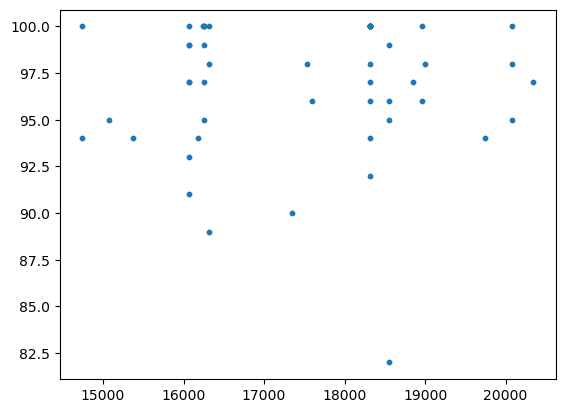

In [114]:
#Bas taux de réussite
df7 = df.loc[df["Informations établissement_Académie"] == "REIMS"]
df7

x = df7.loc[:,"Médiane (€)_Q219"]
y = df7.loc[:,"Taux de réussite bruts_GNLE"]
plt.scatter(x,y, s=10)
plt.show()